In [23]:
from pytorch_lightning.core.mixins import HyperparametersMixin
%load_ext autoreload
%autoreload 2

from gnn_tracking.training.ml import MLModule
from pathlib import Path

from gnn_tracking.utils.loading import TrackingDataModule
import pandas as pd
import numpy as np
from numpy import ndarray as A
import torch
from gnn_tracking.utils.graph_masks import get_good_node_mask
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from gnn_tracking.utils.lightning import find_latest_checkpoint

model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)
chkpt_path = model_exchange_path / "gc" / "gc-7dce6aff.ckpt"
# chkpt_path = find_latest_checkpoint("/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/sectorization/lightning_logs/magenta-wapiti-of-tempering")
lmodel = MLModule.load_from_checkpoint(chkpt_path)


[11:32:02] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[11:32:02] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses


In [4]:

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[11:32:05] INFO: DataLoader will load 900 graphs (out of 900 available).
[11:32:05] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21999_s0.pt
[11:32:05] INFO: DataLoader will load 5 graphs (out of 1000 available).
[11:32:05] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29004_s0.pt


## Plots

In [8]:
data = dm.datasets["val"][3]

out = lmodel(data)
# out

In [9]:
out["H"].shape

torch.Size([55699, 8])

In [10]:

H = out["H"].detach()
h = H.cpu().numpy()
h_oi = h[get_good_node_mask(data.cpu())]

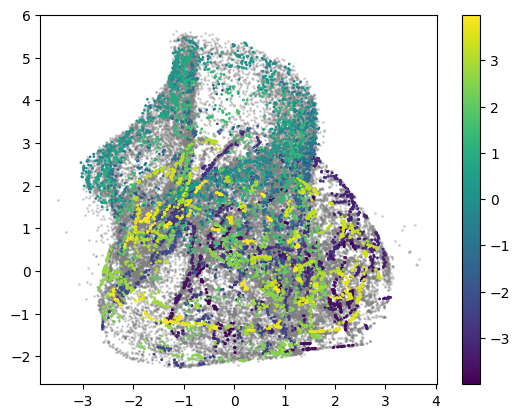

In [26]:
label = torch.zeros_like(data.particle_id, dtype=torch.int)
mask = get_good_node_mask(data)
dims = (0, 3)
plt.scatter(h[~mask, dims[0]], h[~mask, dims[1]], alpha=0.3, s=1, label="Rest", c="gray")
plt.scatter(h[mask, dims[0]], h[mask, dims[1]], alpha=1, s=1, label="Rest", c=data.eta[mask], cmap="viridis")
plt.colorbar()
# plt.scatter(h[mask, 0], h[mask, 1], alpha=0.1, s=1, c="red", label="Eta > 3")

## Evaluation functions

In [29]:

from torch import Tensor as T


def find_n_split(pids: A, labels: A) -> int:
    df = pd.DataFrame({"pid": pids, "label": labels})
    df = df[df.pid > 0]
    return (df.groupby("pid")["label"].nunique() >= 2).sum() / len(np.unique(pids))


## Simply taking a dimension

In [ ]:
def find_best_split_by_dimension(loader, lmodel):
    values = []
    for data in loader:
        gnm = get_good_node_mask(data.cuda())
        doi = data.subgraph(gnm)
        H = lmodel(doi)["H"]
        _values = []
        for i in range(H.shape[1]):
            axis = H[:,i]
            axis -= axis.mean()
            labels = (axis < 0).long()
            _values.append(find_n_split(doi.particle_id.cpu().detach().numpy(), labels.cpu().detach().numpy()))
        values.append(_values)
    means = np.array(values).mean(axis=0)
    errs = np.array(values).std(axis=0) / np.sqrt(len(values))
    return pd.DataFrame({"mean": means, "err": errs})

In [22]:
find_best_split_by_dimension(dm.val_dataloader(), lmodel)

,mean,err
0,0.031297,0.002507
1,0.050726,0.004613


## TSNE

In [93]:
from sklearn.manifold import TSNE

In [95]:
H = lmodel(doi)["H"]

In [97]:
X_embedded = TSNE(n_components=1, learning_rate='auto').fit_transform(H.detach().cpu().numpy())

In [98]:
X_embedded -= X_embedded.mean()

In [130]:
X_embedded = X_embedded.squeeze()

In [161]:
quantiles = np.quantile(X_embedded, np.linspace(0, 1, 12)[1:-1])

In [162]:
labels = torch.zeros_like(doi.particle_id, dtype=torch.int)
for i_quantile, quantile in enumerate(quantiles):
    lower = -np.inf
    upper = np.inf
    if i_quantile > 0:
        lower = quantiles[i_quantile - 1]
    if i_quantile < len(quantiles) - 1:
        upper = quantiles[i_quantile + 1]
    mask = (X_embedded > lower) & (X_embedded < upper)
    labels[mask] = i_quantile

In [163]:
find_n_split(doi.particle_id.detach().cpu().numpy(), labels)

0.0203527815468114

In [164]:
labels.unique().size()

torch.Size([10])

## KMeans

In [167]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(H.detach().cpu().numpy())
labels = kmeans.labels_

In [168]:
find_n_split(doi.particle_id.detach().cpu().numpy(), labels)

0.08344640434192672

## Eta hit

In [7]:
etas = []
for data in dm.val_dataloader():
    etas.append(data.x.detach().cpu().numpy()[:, 3])
big_eta = np.concatenate(etas)
eta_quantiles = np.quantile(big_eta[~np.isnan(big_eta)], np.linspace(0, 1, 12))

In [101]:
mask = get_good_node_mask(data)

doi = data.subgraph(mask)


In [68]:
eta_quantized = np.searchsorted(eta_quantiles, eta)
labels = eta_quantized

eta.shape, labels.shape, doi.particle_id.shape

((8557,), (8557,), torch.Size([8557]))

In [69]:
find_n_split(doi.particle_id.detach().cpu().numpy(), labels)

0.4009700889248181

In [77]:
len(np.unique(labels))

12

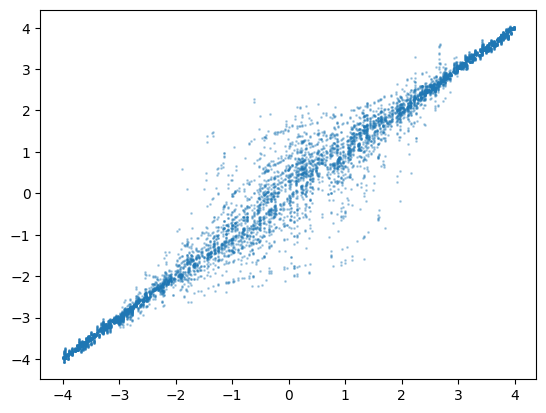

In [74]:
plt.scatter(doi.eta, doi.x[:, 3], alpha=0.3, s=1)

## Train embedding with quantiled PIDs

In [35]:
from torch_geometric.data import Data
from torch import nn

class CategorizePIDs(nn.Module, HyperparametersMixin):
    def __init__(self, quantiles: list[float]):
        super().__init__()
        self.save_hyperparameters()

    def forward(self, data: Data) -> Data:
        data.old_particle_id = data.particle_id
        quantiles = self.hparams.quantiles
        for i_quantile in range(len(quantiles)):
            lower = -np.inf
            upper = np.inf
            if i_quantile > 0:
                lower = quantiles[i_quantile - 1]
            if i_quantile < len(quantiles) - 1:
                upper = quantiles[i_quantile + 1]
            mask = (data.eta > lower) & (data.eta < upper)
            # make sure we exclude noise
            data.particle_id[mask] = i_quantile + 1
        return data

In [36]:
cp = CategorizePIDs(quantiles=eta_quantiles[1:-1])

In [43]:
from gnn_tracking.metrics.losses import GraphConstructionHingeEmbeddingLoss
from gnn_tracking.models.graph_construction import GraphConstructionFCNN

model = GraphConstructionFCNN(
    beta= 0.4,
  depth= 6,
  hidden_dim= 256,
  in_dim= 14,
  out_dim= 2,
)
loss = GraphConstructionHingeEmbeddingLoss(
  attr_pt_thld= 0.9,
  max_num_neighbors= 256,
  p_attr= 2,
  p_rep= 2,
  r_emb= 1,
)

gc = MLModule(
    model=model,
    loss_fct=loss,
    lw_repulsive=0.01,
    preproc=cp,
    # optimizer=
)

In [44]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from gnn_tracking.training.callbacks import PrintValidationMetrics
from pytorch_lightning import Trainer

torch.set_float32_matmul_precision("medium")
trainer = Trainer(
    accelerator="cuda",
    callbacks=[
        PrintValidationMetrics(),
        ModelCheckpoint(save_top_k=2, monitor="total", mode="max"),
        EarlyStopping(monitor="total", mode="min", patience=5),
    ]
)
trainer.fit(gc, dm)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[12:00:45] INFO: DataLoader will load 900 graphs (out of 900 available).
[12:00:45] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

              Validation epoch=0               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Metric                    ┃   Value ┃ Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ attractive                │ 0.13000 │   nan │
│ attractive_train          │ 0.09552 │   nan │
│ attractive_weighted       │ 0.13000 │   nan │
│ attractive_weighted_train │ 0.09552 │   nan │
│ repulsive                 │ 9.17427 │   nan │
│ repulsive_train           │ 9.83355 │   nan │
│ repulsive_weighted        │ 0.09174 │   nan │
│ repulsive_weighted_train  │ 0.09834 │   nan │
│ total                     │ 0.22175 │   nan │
│ total_train               │ 0.19385 │   nan │
└───────────────────────────┴─────────┴───────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=1                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.11486 │ 0.02500 │
│ attractive_train          │ 0.06337 │     nan │
│ attractive_weighted       │ 0.11486 │ 0.02500 │
│ attractive_weighted_train │ 0.06337 │     nan │
│ repulsive                 │ 9.07870 │ 8.56486 │
│ repulsive_train           │ 6.35536 │     nan │
│ repulsive_weighted        │ 0.09079 │ 0.08565 │
│ repulsive_weighted_train  │ 0.06355 │     nan │
│ total                     │ 0.20565 │ 0.06233 │
│ total_train               │ 0.12693 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=2                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.09851 │ 0.00970 │
│ attractive_train          │ 0.08292 │     nan │
│ attractive_weighted       │ 0.09851 │ 0.00970 │
│ attractive_weighted_train │ 0.08292 │     nan │
│ repulsive                 │ 9.27450 │ 0.57311 │
│ repulsive_train           │ 7.78541 │     nan │
│ repulsive_weighted        │ 0.09275 │ 0.00573 │
│ repulsive_weighted_train  │ 0.07785 │     nan │
│ total                     │ 0.19126 │ 0.01278 │
│ total_train               │ 0.16078 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

                Validation epoch=3                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.10391 │ 0.00502 │
│ attractive_train          │  0.12094 │     nan │
│ attractive_weighted       │  0.10391 │ 0.00502 │
│ attractive_weighted_train │  0.12094 │     nan │
│ repulsive                 │  9.92747 │ 0.66648 │
│ repulsive_train           │ 10.61260 │     nan │
│ repulsive_weighted        │  0.09927 │ 0.00666 │
│ repulsive_weighted_train  │  0.10613 │     nan │
│ total                     │  0.20318 │ 0.00810 │
│ total_train               │  0.22707 │     nan │
└───────────────────────────┴──────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=4                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.06916 │ 0.00428 │
│ attractive_train          │ 0.07250 │     nan │
│ attractive_weighted       │ 0.06916 │ 0.00428 │
│ attractive_weighted_train │ 0.07250 │     nan │
│ repulsive                 │ 7.30947 │ 0.67105 │
│ repulsive_train           │ 8.71591 │     nan │
│ repulsive_weighted        │ 0.07309 │ 0.00671 │
│ repulsive_weighted_train  │ 0.08716 │     nan │
│ total                     │ 0.14226 │ 0.00909 │
│ total_train               │ 0.15966 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=5                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.07192 │ 0.00616 │
│ attractive_train          │ 0.07408 │     nan │
│ attractive_weighted       │ 0.07192 │ 0.00616 │
│ attractive_weighted_train │ 0.07408 │     nan │
│ repulsive                 │ 9.34185 │ 0.47530 │
│ repulsive_train           │ 9.63816 │     nan │
│ repulsive_weighted        │ 0.09342 │ 0.00475 │
│ repulsive_weighted_train  │ 0.09638 │     nan │
│ total                     │ 0.16534 │ 0.00731 │
│ total_train               │ 0.17046 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=6                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.05244 │ 0.00522 │
│ attractive_train          │ 0.06646 │     nan │
│ attractive_weighted       │ 0.05244 │ 0.00522 │
│ attractive_weighted_train │ 0.06646 │     nan │
│ repulsive                 │ 8.24069 │ 0.62975 │
│ repulsive_train           │ 7.80865 │     nan │
│ repulsive_weighted        │ 0.08241 │ 0.00630 │
│ repulsive_weighted_train  │ 0.07809 │     nan │
│ total                     │ 0.13485 │ 0.00965 │
│ total_train               │ 0.14454 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=7                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.08161 │ 0.00325 │
│ attractive_train          │ 0.05724 │     nan │
│ attractive_weighted       │ 0.08161 │ 0.00325 │
│ attractive_weighted_train │ 0.05724 │     nan │
│ repulsive                 │ 7.83545 │ 0.56103 │
│ repulsive_train           │ 7.73766 │     nan │
│ repulsive_weighted        │ 0.07835 │ 0.00561 │
│ repulsive_weighted_train  │ 0.07738 │     nan │
│ total                     │ 0.15997 │ 0.00490 │
│ total_train               │ 0.13462 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

               Validation epoch=8                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │ 0.06735 │ 0.00385 │
│ attractive_train          │ 0.05867 │     nan │
│ attractive_weighted       │ 0.06735 │ 0.00385 │
│ attractive_weighted_train │ 0.05867 │     nan │
│ repulsive                 │ 8.07832 │ 0.52222 │
│ repulsive_train           │ 7.52018 │     nan │
│ repulsive_weighted        │ 0.08078 │ 0.00522 │
│ repulsive_weighted_train  │ 0.07520 │     nan │
│ total                     │ 0.14814 │ 0.00757 │
│ total_train               │ 0.13387 │     nan │
└───────────────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

                Validation epoch=9                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                    ┃    Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                │  0.07502 │ 0.00616 │
│ attractive_train          │  0.07637 │     nan │
│ attractive_weighted       │  0.07502 │ 0.00616 │
│ attractive_weighted_train │  0.07637 │     nan │
│ repulsive                 │ 11.12799 │ 0.59459 │
│ repulsive_train           │  7.97925 │     nan │
│ repulsive_weighted        │  0.11128 │ 0.00595 │
│ repulsive_weighted_train  │  0.07979 │     nan │
│ total                     │  0.18630 │ 0.00961 │
│ total_train               │  0.15616 │     nan │
└───────────────────────────┴──────────┴─────────┘



In [39]:
out = gc(data.cuda())

In [40]:
out

{'H': tensor([[ 0.5780, -1.9078],
         [ 0.5477, -1.7157],
         [ 0.5715, -1.8663],
         ...,
         [-1.0679, -1.0633],
         [-1.0610, -0.9980],
         [-1.0624, -1.0155]], device='cuda:0', grad_fn=<MulBackward0>)}

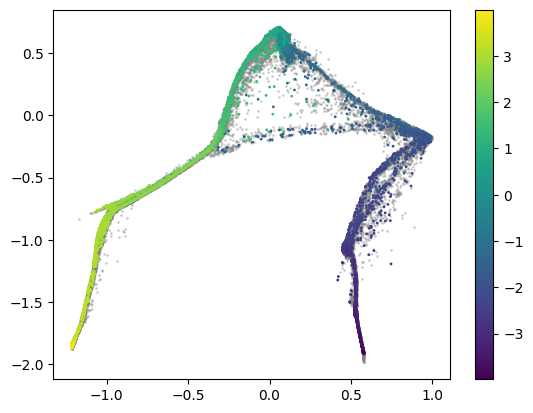

In [42]:
h = out["H"].detach().cpu().numpy()
mask = get_good_node_mask(data).detach().cpu().numpy()
dims = (0, 1)
# mask = None
plt.scatter(h[~mask, dims[0]], h[~mask, dims[1]], alpha=0.3, s=1, label="Rest",
            c="gray")
plt.scatter(h[mask, dims[0]], h[mask, dims[1]], alpha=1, s=1, label="Rest",
            c=data.eta[mask].detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
# plt.xlim(-2.5, 2.5)
# plt.ylim(-2, 2.5)
# plt.scatter(h[mask, 0], h[mask, 1], alpha=0.1, s=1, c="red", label="Eta > 3")